<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

13:18:17 Starting...
13:18:17 Installing yfinance into Google notebook...
13:18:22 Installing arch into Google notebook...
13:18:29 Initialized.


## Get the Data

In [91]:
data,ticker_name=download(ticker:='SPY',end='2019-12-31',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=list(map(lambda x:x.strftime("%A"),data.index))
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=list(map(lambda x:x.strftime("%B"),data.index))
data['FirstPayment']=(data['Monthday']==1)|(data['Monthday'].shift(-1).isin([2,3]))&(data['Month']!=data['Month'].shift(-1))
data['SecondPayment']=(data['Monthday']>=15)&(data['Monthday'].shift()<15)
data['Payday']=(data['FirstPayment']|data['SecondPayment']).apply(lambda x:"Payday" if x else "Regular")
data['DaysSincePayday']=data['Monthday']-(data['Payday'].apply(lambda x:one if x else np.nan)*data['Monthday']).ffill()
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month,FirstPayment,SecondPayment,Payday,DaysSincePayday
1993-02-01,24.626434,24.626434,24.469910,24.469910,480500,0.711294,Monday,1,28,February,True,False,Payday,0.0
1993-02-02,24.678612,24.696003,24.556871,24.609046,201300,0.211876,Tuesday,2,28,February,False,False,Regular,0.0
1993-02-03,24.939478,24.956869,24.695996,24.713388,529400,1.057054,Wednesday,3,28,February,False,False,Regular,0.0
1993-02-04,25.043829,25.096004,24.748173,25.026437,531500,0.418417,Thursday,4,28,February,False,False,Regular,0.0
1993-02-05,25.026432,25.078607,24.887300,25.026432,492100,-0.069466,Friday,5,28,February,False,False,Regular,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917725,297.315186,296.769826,297.259727,52990000,0.152760,Monday,23,31,December,False,False,Regular,0.0
2019-12-24,296.927002,297.195041,296.621953,297.148835,20270000,0.003125,Tuesday,24,31,December,False,False,Regular,0.0
2019-12-26,298.507538,298.516790,297.305902,297.315127,30911200,0.532298,Thursday,26,31,December,False,False,Regular,0.0
2019-12-27,298.433685,299.302571,297.897578,299.247113,42528800,-0.024741,Friday,27,31,December,False,False,Regular,0.0


15:01:17 Wrote plot to Daily Returns of S&P 500 Index ETF.png.


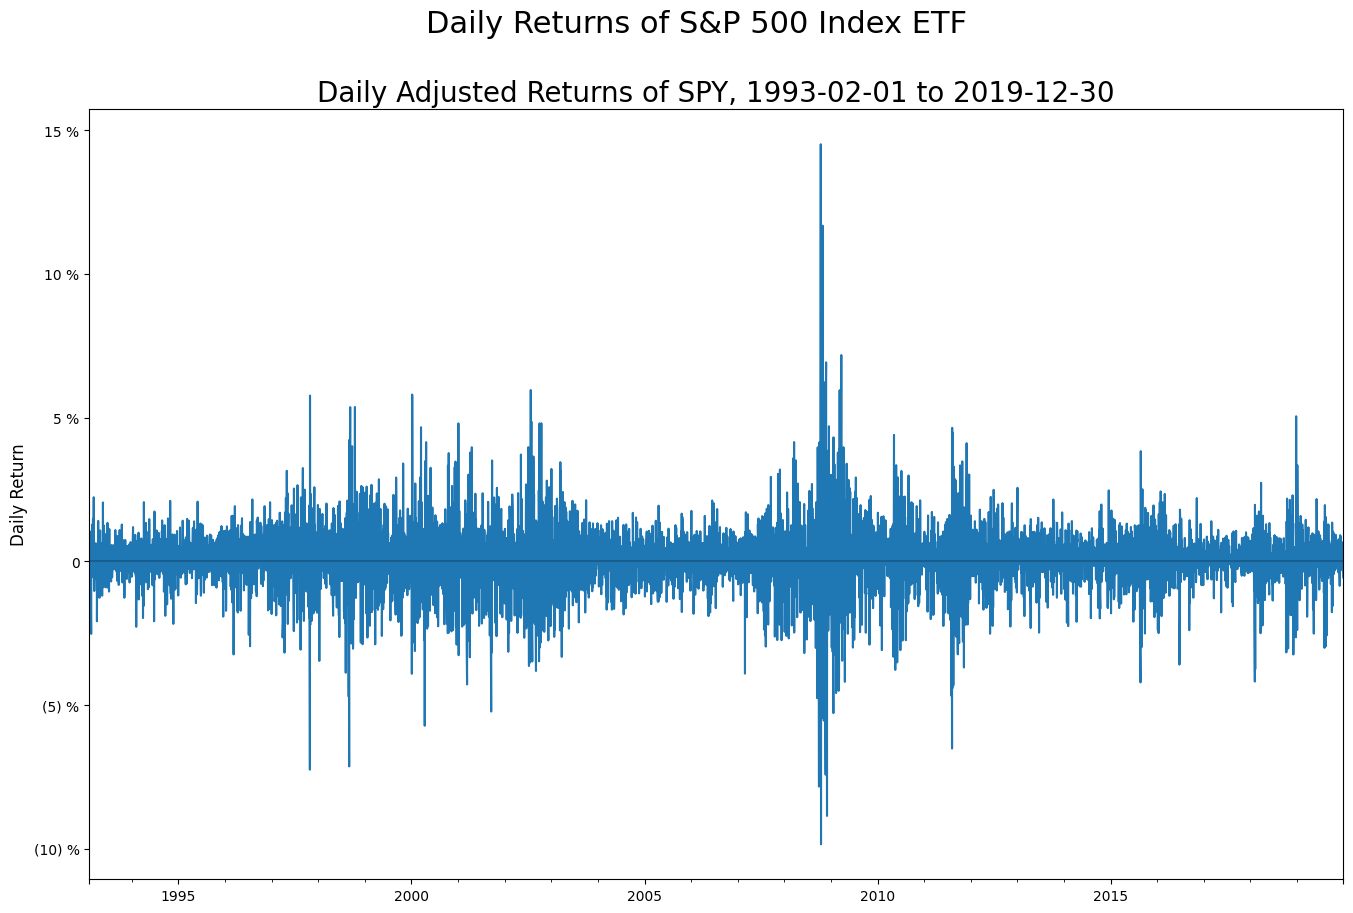

In [92]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
data['Return'].plot(ax=plot)
plot.set_ylabel("Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Daily Returns of {}".format(ticker_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
plot.axhline(color='black',alpha=0.2)
nprint("Wrote plot to {}.".format(filename))

## Analyse Returns by Selected Period
### First Just a Simple Grouped Mean

15:02:41 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value,Significance
Day of Week,,,,,,,
Monday,0.040138,1.264919,1277,0.035397,1.133930,0.257037,
Tuesday,0.071447,1.159080,1389,0.031100,2.297307,0.021750,*
Wednesday,0.051835,1.095635,1390,0.029387,1.763866,0.077974,
Thursday,0.023567,1.126048,1364,0.030489,0.772958,0.439681,
Friday,0.028857,1.064545,1358,0.028888,0.998926,0.318009,


15:02:42 Wrote plot to Average Returns of S&P 500 Index ETF by Day of Week.png.


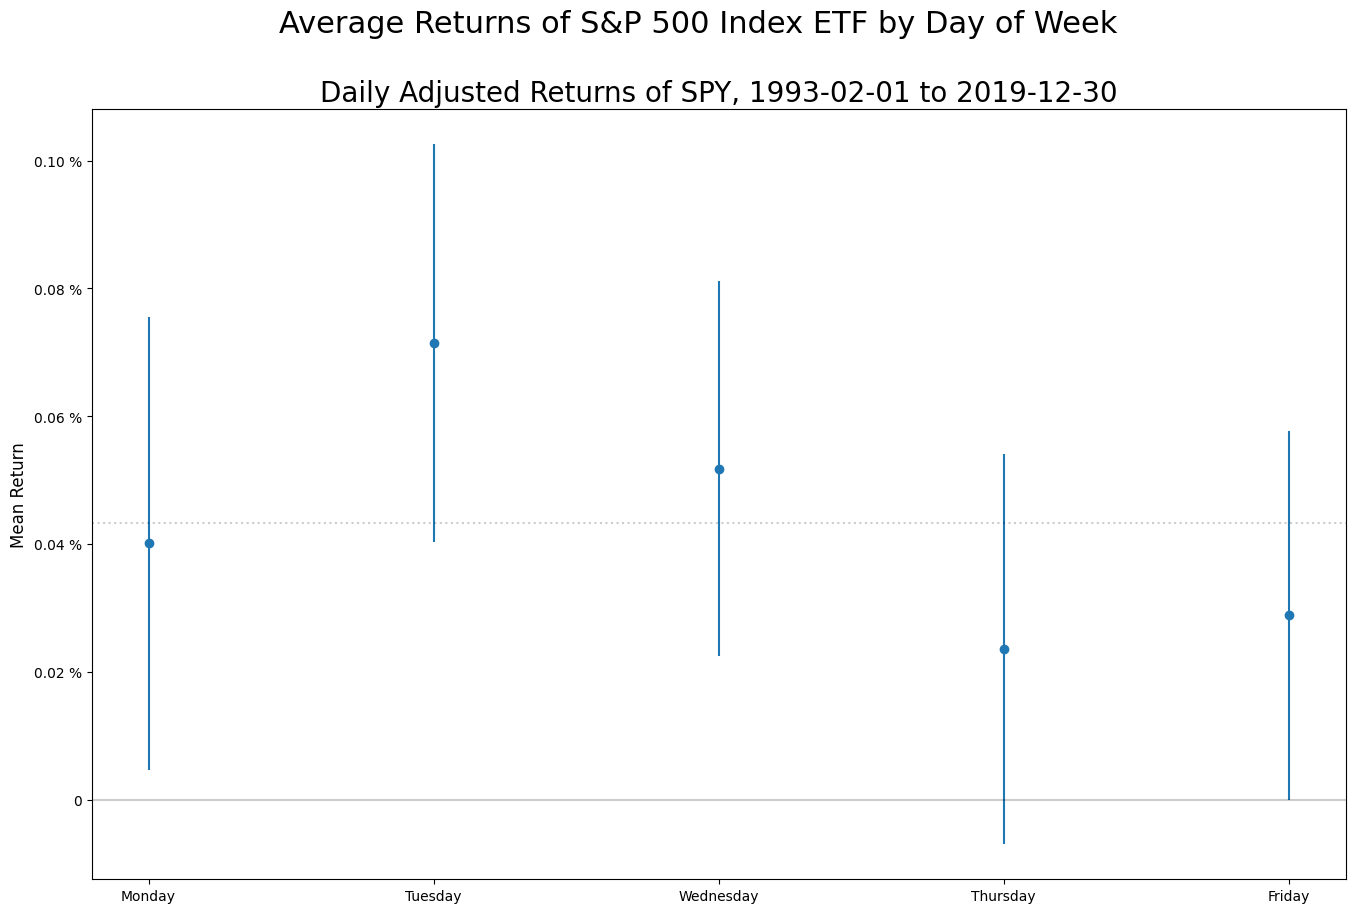

In [99]:
from scipy.stats import t as studentt

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return',group_name:='Weekday']].groupby(group_name)).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
results.index.name=(group_long_name:='Day of Week' if group_name=='Weekday' else 'Day of Month' if group_name=='Monthday' else group_name)

if group_name=='Weekday':
    results=results.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday'])

display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel(group_long_name if group_name=='Monthday' else None,fontsize=12)
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### One Way ANOVA Analysis

In [100]:
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("One Way ANOVA Analysis by {}".format(group_name))
anova=anova_lm(OLSformula("Return ~ {}".format(group_name),data).fit(),typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

15:02:42 One Way ANOVA Analysis by Weekday


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,2.028828,4.0,0.388618,0.816942,
Within Groups,8839.828107,6773.0,,,


### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [101]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data[group_name],columns=[group_name],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

15:02:42 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711294
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211876
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057054
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418417
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069466
...,...,...,...,...,...,...
2019-12-23,1.0,0.0,0.0,0.0,0.0,0.152760
2019-12-24,0.0,1.0,0.0,0.0,0.0,0.003125
2019-12-26,0.0,0.0,0.0,1.0,0.0,0.532298
2019-12-27,0.0,0.0,0.0,0.0,1.0,-0.024741


15:02:42                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3886
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.817
Time:                        15:02:42   Log-Likelihood:                -10518.
No. Observations:                6778   AIC:                         2.105e+04
Df Residuals:                    6773   BIC:                         2.108e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0401      0.032      1.256

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

In [102]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False,lags=0)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan,zero,zero,zero]+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
display(results.replace(np.nan,""))

15:02:42 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8763.595171374054
            Iterations: 19
            Function evaluations: 241
            Gradient evaluations: 19
15:02:43                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8763.60
Distribution:      Generalized Error Distribution   AIC:                           17547.2
Method:                        Maximum Likelihood   BIC:                           17615.4
                                                    No. Observations:                 6778
Date:                            Mon, Apr 28 2025   Df Residuals:                  

,Estimate,Std.Err.,Null Value,t Score,p Value,Significance
Monday,0.053278,0.019008,0.0,2.802987,0.005063,**
Tuesday,0.035985,0.021171,0.0,1.699719,0.089184,
Wednesday,0.075193,0.018035,0.0,4.169187,0.000031,***
Thursday,0.042092,0.019552,0.0,2.152791,0.031335,*
Friday,0.071240,0.020470,0.0,3.480294,0.000501,***
omega,0.017797,0.003186,,,,
alpha[1],-0.001304,0.006676,0.0,-0.195282,0.845172,
gamma[1],0.196251,0.023180,0.0,8.466497,0.0,***
beta[1],0.886568,0.012111,0.0,73.20243,0.0,***
nu,1.354816,0.037185,2.0,-17.350684,0.0,***


### Repeat the Simple Plot by Selected Period

15:02:43 Wrote plot to Estimated Daily Returns of S&P 500 Index ETF by Day of Week.png.


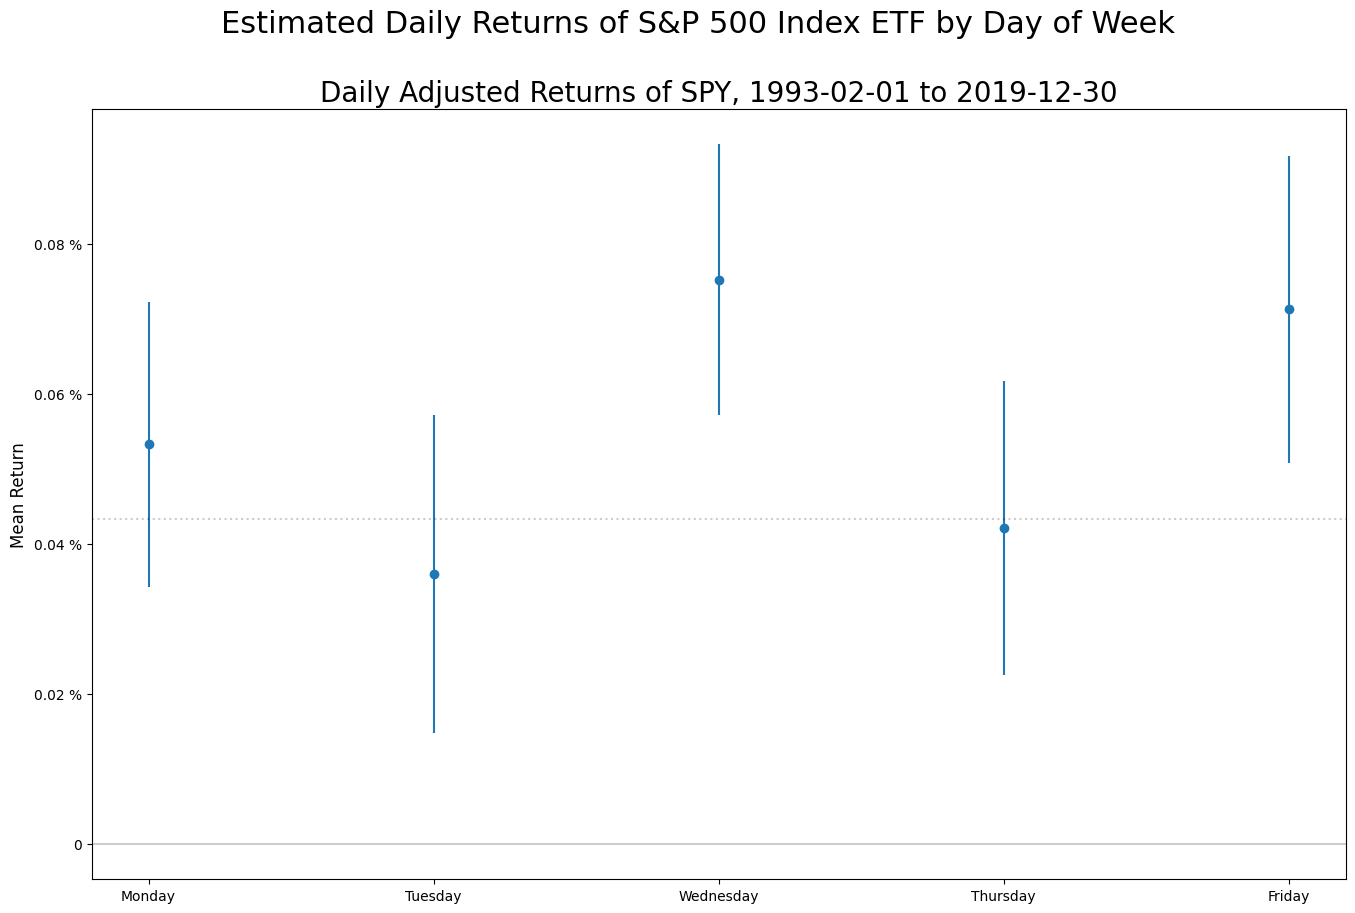

In [103]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index[:-5],results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Estimated Daily Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Compute the MLRT and AIC changes

In [104]:
from scipy.stats import chi2

aic=pd.DataFrame({
    'Model':['OLS','GJR-GARCH(1,1,1)'],
    'AIC':[ols_fit.aic,gjr_fit.aic],
    '-logL':[ols_fit.llf,gjr_fit.loglikelihood],
    'params':[ols_fit.params.shape[0]+1,gjr_fit.params.shape[0]]
}).set_index('Model')
aic.loc['Change']=aic.diff().iloc[-1]
aic.loc['Change','Chi.Sq.']=aic.loc['Change','-logL']*two
aic.loc['Change','p Value']=chi2.sf(aic.loc['Change','Chi.Sq.'],aic.loc['Change','params'])
display(aic.replace(np.nan,""))

,AIC,-logL,params,Chi.Sq.,p Value
Model,,,,,
OLS,21045.268315,-10517.634157,6.0,,
"GJR-GARCH(1,1,1)",17547.190343,-8763.595171,10.0,,
Change,-3498.077972,1754.038986,4.0,3508.077972,0.0
